In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow import optimizers
from keras.layers import Embedding, LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews-clean/clean_reviews.csv')
df.head()

,clean_reviews,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,mattei love time money visually stunning film ...,positive


In [3]:
df.loc[df['sentiment'] == 'negative', 'sentiment'] = 0
df.loc[df['sentiment'] == 'positive', 'sentiment'] = 1
df['sentiment'] = df['sentiment'].astype('int32')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_reviews  50000 non-null  object
 1   sentiment      50000 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 586.1+ KB


In [5]:
df['length'] = [len(x.split()) for x in df['clean_reviews']]

In [6]:
np.mean(df['length'])

117.88286

# Tokenize

In [7]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 10

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(df['clean_reviews'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 39522 unique tokens.


In [8]:
X = tokenizer.texts_to_sequences(df['clean_reviews'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print('Shape of data tensor:', X.shape)
X

Shape of data tensor: (50000, 100)


array([[  3, 927,  57, ...,   0,   0,   0],
       [276,  41, 239, ...,   0,   0,   0],
       [ 91, 276,  23, ...,   0,   0,   0],
       ...,
       [186, 250, 974, ...,   0,   0,   0],
       [ 64, 791, 785, ...,   0,   0,   0],
       [  3, 209,  24, ...,   0,   0,   0]], dtype=int32)

# Train-Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, np.array(df['sentiment']), random_state=42, test_size=0.2, stratify=df['sentiment'])

In [10]:
X_real_train, X_valid, y_real_train, y_valid = train_test_split(X_train, y_train, random_state=42, test_size=0.2, stratify=y_train)

In [11]:
X_real_train.shape

(32000, 100)

In [12]:
X_real_train

array([[152, 286, 906, ...,   8, 225, 159],
       [433, 127,  18, ...,   0,   0,   0],
       [508, 213, 174, ...,   0,   0,   0],
       ...,
       [  1, 369, 156, ...,   0,   0,   0],
       [327, 228,  37, ...,   0,   0,   0],
       [757, 247, 445, ...,   0,   0,   0]], dtype=int32)

# Model

In [21]:
tf.keras.backend.clear_session()

model=Sequential(name="LSTM_dropout")
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, mask_zero=True))
model.add(LSTM(140, input_shape=(X_real_train.shape)))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

model.summary()

Model: "LSTM_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          10000     
_________________________________________________________________
lstm (LSTM)                  (None, 140)               84560     
_________________________________________________________________
dense (Dense)                (None, 1)                 141       
Total params: 94,701
Trainable params: 94,701
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(X_real_train, y_real_train, 
                    validation_data=(X_valid, y_valid),
                    epochs=10)

Epoch 1/10
1000/1000 [==============================] - 14s 11ms/step - loss: 0.4003 - accuracy: 0.8177 - val_loss: 0.3318 - val_accuracy: 0.8599
Epoch 2/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3280 - accuracy: 0.8637 - val_loss: 0.3344 - val_accuracy: 0.8596
Epoch 3/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3169 - accuracy: 0.8683 - val_loss: 0.3263 - val_accuracy: 0.8581
Epoch 4/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.3049 - accuracy: 0.8729 - val_loss: 0.3366 - val_accuracy: 0.8537
Epoch 5/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2962 - accuracy: 0.8778 - val_loss: 0.3209 - val_accuracy: 0.8624
Epoch 6/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2907 - accuracy: 0.8791 - val_loss: 0.3258 - val_accuracy: 0.8620
Epoch 7/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2811 - accuracy: 0.8829 - val_loss: 0.3205 -

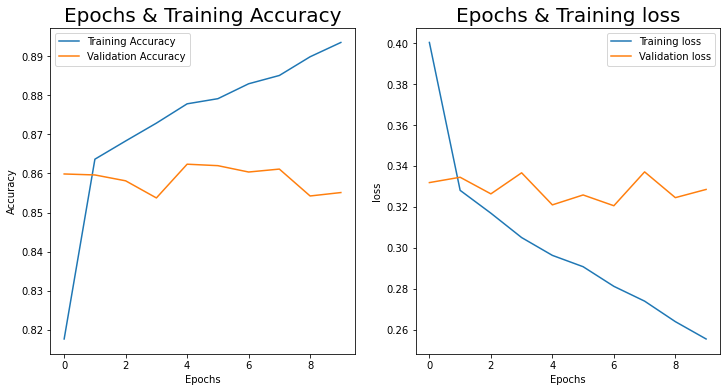

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history.history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(history.history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history.history['loss'], '-', label = 'Training loss')
ax[1].plot(history.history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [24]:
pred = model.predict(X_test)
pred = [1 if y >= 0.5 else 0 for y in pred]

print(accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

0.8598
              precision    recall  f1-score   support

           0       0.89      0.83      0.85      5000
           1       0.84      0.89      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



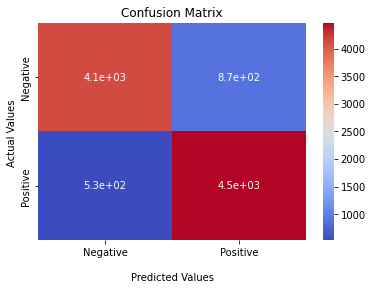

In [25]:
cf_matrix = confusion_matrix(y_test, pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='coolwarm')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])

plt.show()

In [26]:
cf_matrix

array([[4126,  874],
       [ 528, 4472]])